# CB1020 Project in mathematical modelling

## Modeling of disease progression of malaria in humans with and without heterozygotic sickle cell trait using ABM

#### Group 7
* Ankita Poppel
* Sofia Franzen
* Malakai James O'Connor
* Trine Ollden
* Klara Nordwall
* Athina Rasidaki
* Kanstantin Kazlou

### Small Summary

We used agent based modelling to simulate a simplified disease progression of malaria inside the blood stream. There are two agent classes; red blood cells and malaria merozoites. Every time step the agents perform their respective functions simultaneously and independently. Merozoites move randomly through the cells and have a chance of attaching themselves to a red blood cell upon meeting, leading to infection. We assume that the red blood cells are perfectly spread out, and therefore the blood cells are not modelled to move. If a red blood cell is infected, the merozoites will develop and cause the cells to burst after a delay, creating more merozoites in surrounding cells. In heterozygote sickle cells, the infection has a chance of sickling the cell, which then results in elimination of the infected erythrocyte without outburst of merozoites.

### Import of libraries

Agent and Model are already defined classes imported from Mesa framework. The CellAgent is used to mimic the agent's movement and interaction with cells in the bloodstream whilst FixedAgent is used to create non-moving blood cells. MultiGrid is used to set up our 2D grid.DataCollector is used to store data from our simulation. 

In [39]:
# libraries to import
from mesa import Agent, Model
from mesa.discrete_space import CellAgent, FixedAgent
from mesa.datacollection import DataCollector
from mesa.space import MultiGrid

import matplotlib.pyplot as plt
import math
import random
import numpy as np

### Simple Scheduler

In [28]:
# custom scheduler 
class SimpleScheduler:
    """ Class implementing SimpleScheduler. 
    
    Gives the order in which the agents should act. """
    
    def __init__(self):
        self.agents = []

    def add(self, agent):
        self.agents.append(agent)

    def remove(self, agent):
        if agent in self.agents:
            self.agents.remove(agent)

    def step(self):
        # Loop through a copy to allow safe removal
        for agent in self.agents[:]:
            agent.step()

### Agents

Our model includes two agents - Merozoite and BloodCell that interact with each other. The Merozoite agent represents the merozoites found in a malaria infection, it is mobile and infects red blood cells. BloodCell agents represent the erythrocytes in the blood stream which we model as stationary. They function slightly differently depending on whether they have the sickle trait genotype or not ("heterozygous" or "normal"). 

A unique id is assigned to each agent, which allows for scheduling of actions. 


### Merozoite

The merozoite agent moves randomly through the grid by jumping to a random neighboring tile each time step. If a red blood cell is encountered, it is infected. 


In [29]:
# merozoites 
class Merozoite(Agent):
    """ Class implementing Merozoite"""
    
    
    def __init__(self, unique_id, model, pos):
        """ Initialize an Merozoite.

        Args:
            unique_id: Gives each agent an unique id
            model: Model instance
            pos: Position """ 
        
        self.unique_id = unique_id
        self.model = model
        self.pos = pos

    def step(self):
        """Execute one step of the merozoite lifecycle""" 
        # Move randomly to a neighboring cell 
        neighbors = self.model.grid.get_neighborhood(self.pos, moore=True, include_center=False)
        new_pos = random.choice(neighbors)
        self.model.grid.move_agent(self, new_pos)

        # Try to infect any RBC in the new position
        cell_agents = self.model.grid.get_cell_list_contents([new_pos])
        for agent in cell_agents:
            if isinstance(agent, BloodCell):
                agent.infect()


### BloodCell

Erhytrocytes are modeled by the BloodCell agent, which is stationary and has a health pool that is used to control the gestation period. When the gestation period ends, the cells with the sickle trait (genotype = "heterozygous") has a chance to get consumed by macrophages, otherwise the cell bursts. A burst creates new merozoites around the blood cell, after which it disappears.

In [30]:
# defining agents and behavior 
# blood cell 
class BloodCell(Agent):
    """ Class implementing Bloodcell"""
    
    def __init__(self,  unique_id, model, pos, genotype="normal", infection_risk=0.5):
        """ Initialize an Bloodcell.

        Args:
            unique_id: Gives each agent an unique id
            model: Model instance
            pos: Position 
            genotype: Genotype (normal or heterozygous)
            infection_risk: Risk of infection""" 
        
        self.model = model
        self.unique_id = unique_id
        self.pos = pos
        self.genotype = genotype
        self.infection_risk = infection_risk
        self.hp = 24 #Creates the gestation period during step if infected
        self.infected = False #Starts as non infected

    def step(self):
        """Execute one step of the Bloodcell cycle""" 
        if self.infected:
            self.hp -= 1 #If infected, the healthpoint decreases with one for each step
        if self.infected and self.hp <= 0: #When healthpoint = 0, the cell either burst or dies (see resolve)
            self.resolve()

    def infect(self):
        """Infection of non infected RBCs when merozoite and bloodcell encounter each other""" 
        #Called by a merozoite attempting to infect a RBC
        if not self.infected:
            if random.random() < self.infection_risk:
                self.infected = True
                self.hp = 23  # triggers bursting/removal in a few steps

    def resolve(self):
        """When healthpoint = 0, either burst or die based on genotype""" 
        #Handle bursting or dying based on genotype
        if self.genotype == "normal":
            self.burst()
        elif self.genotype == "heterozygous":
            if random.random() < 0.5:
                self.burst()  # 50% chance to burst
            # otherwise dies quietly

        # Remove the RBC in all cases - the infected RBC that burst and the heterozygous ones that sickle 
        self.model.grid.remove_agent(self)
        self.model.schedule.remove(self)

    def burst(self):
        """If burst of bloodcell, release of merozoites""" 
        #Produce 20 new merozoites in neighboring empty cells
        neighbors = self.model.grid.get_neighborhood(self.pos, moore=True, include_center=False)
        empty_spaces = [pos for pos in neighbors if self.model.grid.is_cell_empty(pos)]
        # Find all empty neighboring cells where new merozoites can be placed
        for _ in range(20):  #Creates 20 merozites. 
            if empty_spaces:
                pos = empty_spaces.pop()
                mero = Merozoite(self.model.next_id(), self.model, None)
                self.model.grid.place_agent(mero, pos)
                self.model.schedule.add(mero)
                

### Malaria Model

We define one model with a certain grid and start values for merozoites and RBCs, in which we can change the genotype parameter to "normal" or "heterozygous". The agens are created and data is collected for each step. 

In [31]:
class MalariaModel1(Model):
    """ Class implementing the Malaria Model"""
    
    def __init__(self, width=10, height=10, n_rbc=70, n_mero=5, genotype="normal"):
        super().__init__()

        """ Initialize the model.

        Args:
            width: Width of the grid
            height: Height of the grid
            n_rbc: Number of red blood cells to start with
            n_mero: Number of merozoites to start with
            genotype: Genotype (normal or heterozygous)
            """ 
        
        self.grid = MultiGrid(width, height, True)
        self.schedule = SimpleScheduler() 
        self.current_id = 0  # initialize counter

        # Create RBCs
        for _ in range(n_rbc): # loops until we get n_rbc 
            x = self.random.randrange(width) # random placement on grid 
            y = self.random.randrange(height)
            rbc = BloodCell(self.next_id(), self, None, genotype=genotype) # unique id, initial position and genotype 
            self.grid.place_agent(rbc, (x, y)) # puts the agent on the grid
            self.schedule.add(rbc) #says which agent will take a turn each round

        # Create Merozoites
        for _ in range(n_mero): # loops until we get n_mero
            x = self.random.randrange(width) # random placement on grid 
            y = self.random.randrange(height)
            mero = Merozoite(self.next_id(), self, None) # unique id, initial position
            self.grid.place_agent(mero, (x, y)) # puts the agent on the grid
            self.schedule.add(mero) #says which agent will take a turn each round

        # Set up data collection
        # "Merozoites" and "RBCs" counts the active number of agents for respective group
        self.datacollector = DataCollector(
            model_reporters={
                "Merozoites": lambda m: sum(isinstance(a, Merozoite) for a in m.schedule.agents),
                "RBCs": lambda m: sum(isinstance(a, BloodCell) for a in m.schedule.agents),
            }
        )

    def next_id(self):
        """Goes to the next agent"""
        self.current_id += 1
        return self.current_id
    
    def step(self):
        """Execute one step of the model"""
        self.datacollector.collect(self)
        self.schedule.step()

### Results 

#### Results after one simulation 
After the simulation is complete, the data collected from the run is presented in a graph which shows the time progression of merozoite and RBC amounts. The time progression for the two genotypes is presented both separately and together for comparison.

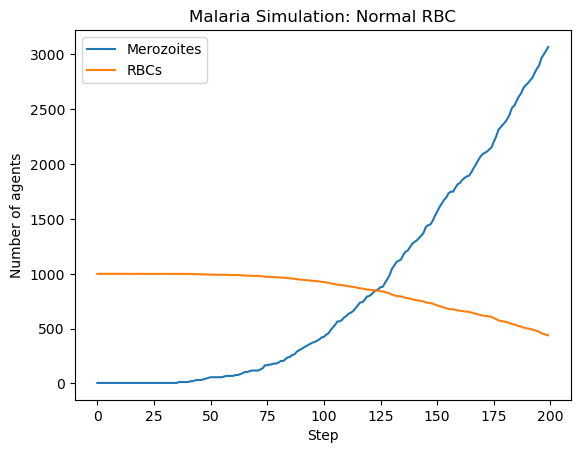

In [33]:
# simulation for healthy RBC with plot 

# Create a model instance
model1 = MalariaModel1(width=100, height=100, n_rbc=1000, n_mero=5, genotype="normal")

n_steps = 200  # number of time steps to simulate

# Run the simulation
for i in range(n_steps):
    model1.step()  # use the correct instance

# Convert collected data to pandas DataFrame
df1 = model1.datacollector.get_model_vars_dataframe()

# Plot results
df1.plot()
plt.xlabel("Step")
plt.ylabel("Number of agents")
plt.title("Malaria Simulation: Normal RBC")
plt.show()

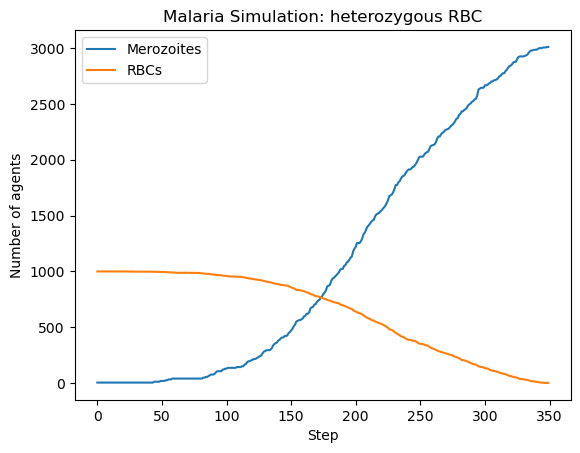

In [51]:
# simulation for heterozygous RBC with plot 

# Create a model instance
model2 = MalariaModel1(width=100, height=100, n_rbc=1000, n_mero=5, genotype="heterozygous") 

n_steps = 350  # number of time steps to simulate

# Run the simulation
for i in range(n_steps):
    model2.step()  # use the correct instance

# Convert collected data to pandas DataFrame
df2 = model2.datacollector.get_model_vars_dataframe()

# Plot results
df2.plot()
plt.xlabel("Step")
plt.ylabel("Number of agents")
plt.title("Malaria Simulation: heterozygous RBC")
plt.show()

In [35]:
# Prints the first and last five measures of the dataframe with normal RBCs
print(df1) 

     Merozoites  RBCs
0             5  1000
1             5  1000
2             5  1000
3             5  1000
4             5  1000
..          ...   ...
195        2901   472
196        2967   458
197        3000   452
198        3032   446
199        3069   439

[200 rows x 2 columns]


In [36]:
# Prints the first and last five measures of the dataframe with heterozygous RBCs
print(df2) 

     Merozoites  RBCs
0             5  1000
1             5  1000
2             5  1000
3             5  1000
4             5  1000
..          ...   ...
195        1408   536
196        1433   531
197        1466   523
198        1485   516
199        1499   510

[200 rows x 2 columns]


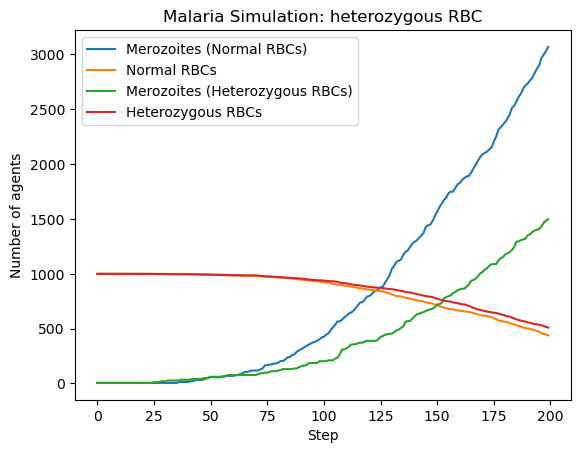

In [37]:
# Plot both results in the same plot

plt.plot(df1['Merozoites'], label='Merozoites (Normal RBCs)')
plt.plot(df1['RBCs'], label='Normal RBCs')
plt.plot(df2['Merozoites'], label='Merozoites (Heterozygous RBCs)')
plt.plot(df2['RBCs'], label='Heterozygous RBCs')
plt.xlabel("Step")
plt.ylabel("Number of agents")
plt.title("Malaria Simulation: heterozygous RBC")
plt.legend()
plt.show()

#### Calculation of mean results after n simulations

Beacuse the simulation has random elements and yield different results every time, a mean number of merozoites and RBCs at the end of the simulation need to be calculated to get the most accurate result. The calc_mean function runs the simulation a set number of times and calculates the mean number of merozoites and RBCs after every simulation is run.  When this is plotted later it is possible to see where the mean value stabilizes, indicating that enough simulations have been done to get a good mean value. 

In [41]:
def calc_mean(n_sim, n_steps, gene): 
    """ Calculates the meanvalues of Meroziotes and RBCs after running the stimulation n_sim times
        and puts them in a list. After each simulation an new mean-value is added and the new mean 
        of the list is calculated. 
        """
    
    merozoite_numbers = []
    RBC_numbers = []
    merozoite_means = []
    RBC_means = []

    for i in range(n_sim):

        model = MalariaModel1(width=100, height=100, n_rbc=1000, n_mero=5, genotype=gene)

        # Run the simulation
        for n in range(n_steps):
            model.step()  # use the correct instance

        # Convert collected data to pandas DataFrame
        df = model.datacollector.get_model_vars_dataframe()

        merozoite_numbers.append(df['Merozoites'].iloc[-1])
        RBC_numbers.append(df['RBCs'].iloc[-1])

        merozoite_means.append(np.mean(merozoite_numbers))
        RBC_means.append(np.mean(RBC_numbers))

    return merozoite_means, RBC_means

In [45]:
# Calculates the mean value after 100 simulations with normal RBCs
merozoite_means1, RBC_means1 = calc_mean(100, 200, 'normal')

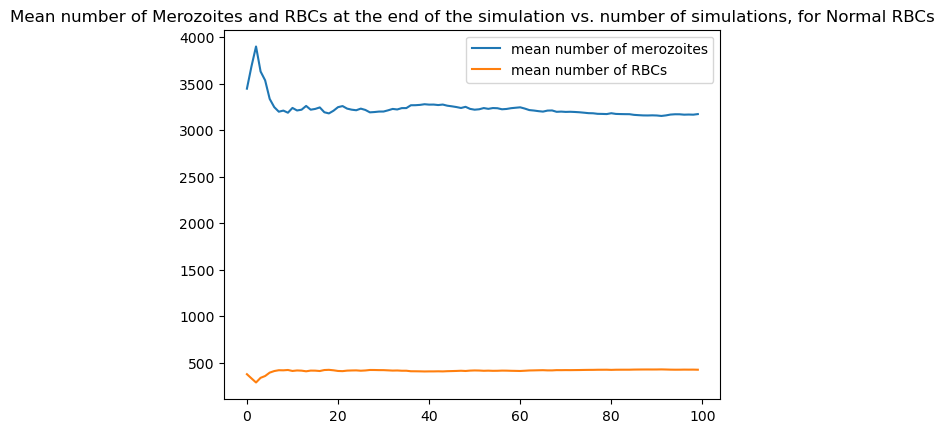

In [46]:
# Plots the means over number of simulations 
plt.plot( merozoite_means1,  label = 'mean number of merozoites')
plt.plot( RBC_means1, label = 'mean number of RBCs')
plt.title('Mean number of Merozoites and RBCs at the end of the simulation vs. number of simulations, for Normal RBCs')
plt.legend()
plt.show()

In [47]:
# Prints the last mean-value for amount of Merozoites and RBCs for normal RBCs
print(merozoite_means1[-1], RBC_means1[-1])

3173.7 425.13


In [48]:
# Calculates the mean value after 100 simulations with heterozygous RBCs
merozoite_means2, RBC_means2 = calc_mean(100, 200, 'heterozygous')

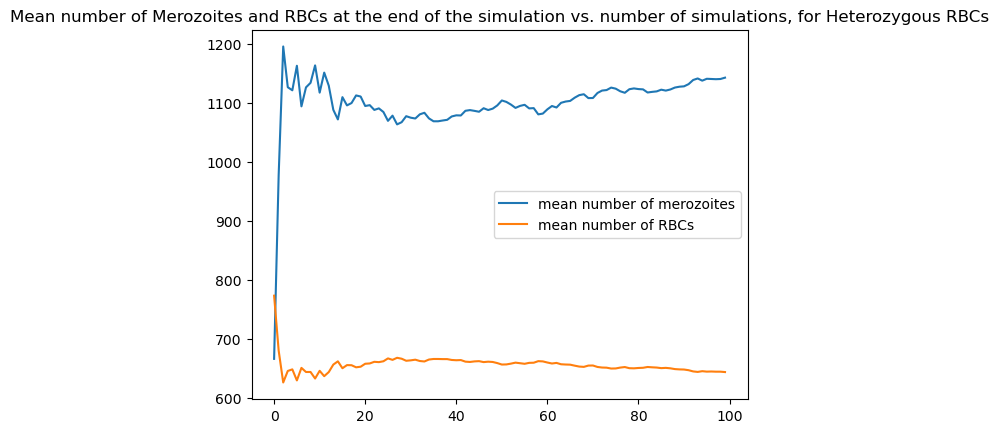

In [49]:
plt.plot( merozoite_means2,  label = 'mean number of merozoites')
plt.plot( RBC_means2, label = 'mean number of RBCs')
plt.title('Mean number of Merozoites and RBCs at the end of the simulation vs. number of simulations, for Heterozygous RBCs')
plt.legend()
plt.show()

In [50]:
# Prints the last mean-value for amount of Merozoites and RBCs for heterozygous RBCs
print(merozoite_means2[-1], RBC_means2[-1])

1142.2 643.64
